In [21]:
!pip install pandas numpy matplotlib tensorflow yfinance

In [23]:
# Gerekli kütüphanelerin import edilmesi
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [25]:
# 1. Veri Çekme Fonksiyonu
def veri_cekme(coin='BTC-USD', baslangic='2022-01-01', bitis='2023-01-01'):
    # Seçilen tarihler aralığında kripto para verisini çek
    data = yf.download(coin, start=baslangic, end=bitis, interval='1d')
    data = data[['Close']]  # Yalnızca kapanış fiyatlarını al
    data = data.dropna()  # Eksik verileri temizle
    return data

In [41]:
def model_egit(data, epochs=5):
    # Veriyi ölçekleme
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # Eğitim verisi hazırlığı
    X_train, y_train = [], []
    for i in range(60, len(scaled_data)):
        X_train.append(scaled_data[i-60:i, 0])
        y_train.append(scaled_data[i, 0])
    
    # Eğitim verisi boyut kontrolü
    if len(X_train) == 0:
        raise ValueError("Model eğitimi için yeterli veri yok. En az 60 günlük veriye ihtiyaç var.")
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # Modeli oluşturma
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    
    # Modeli derleme
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=1, epochs=epochs)
    
    return model, scaler


In [43]:
# 3. Tahmin Yapma Fonksiyonu
def tahmin_yap(model, data, scaler, tahmin_baslangic, tahmin_bitis):
    # Son 60 gün verisi ile tahmin yapmak için veriyi hazırlama
    tahmin_verisi = data[-60:].values
    tahmin_verisi = scaler.transform(tahmin_verisi)
    
    # Gelecek günler için tarih aralığı
    tarih_araligi = pd.date_range(start=tahmin_baslangic, end=tahmin_bitis)
    tahminler = []
    
    # Her bir gün için adım adım tahmin yapma
    for _ in range(len(tarih_araligi)):
        X_test = np.reshape(tahmin_verisi, (1, tahmin_verisi.shape[0], 1))
        tahmin = model.predict(X_test)
        tahmin_tersi = scaler.inverse_transform(tahmin)
        tahminler.append(tahmin_tersi[0, 0])
        
        # Bir sonraki tahmin için veriyi güncelleme
        yeni_veri = np.append(tahmin_verisi, tahmin)[1:]
        tahmin_verisi = np.reshape(yeni_veri, (60, 1))
    
    # Tahmin verilerini DataFrame olarak döndürme
    tahmin_df = pd.DataFrame(data=tahminler, index=tarih_araligi, columns=["Tahmin"])
    return tahmin_df

In [45]:
# 4. Grafik Gösterimi Fonksiyonu
def grafikleri_goster(orijinal_data, tahmin_data):
    plt.figure(figsize=(14,5))
    plt.plot(orijinal_data, color="blue", label="Gerçek Fiyat")
    plt.plot(tahmin_data, color="red", label="Tahmin Fiyat")
    plt.xlabel('Tarih')
    plt.ylabel('Fiyat')
    plt.legend()
    plt.show()

In [47]:
# 5. Kullanıcıdan Tarih Girişi Alma Fonksiyonu
def tarih_girdisi_al():
    try:
        baslangic = input("Tahmin için başlangıç tarihini girin (YYYY-MM-DD): ")
        bitis = input("Tahmin için bitiş tarihini girin (YYYY-MM-DD): ")
        baslangic_dt = datetime.strptime(baslangic, '%Y-%m-%d')
        bitis_dt = datetime.strptime(bitis, '%Y-%m-%d')
        
        if baslangic_dt >= bitis_dt:
            raise ValueError("Başlangıç tarihi bitiş tarihinden önce olmalıdır.")
        
        return baslangic, bitis
    except ValueError as e:
        print(f"Hatalı tarih girişi: {e}")
        return tarih_girdisi_al()

In [49]:
# 6. Tüm Süreci Çalıştırma
def tahmin_botu():
    # Kullanıcıdan tarih al
    baslangic, bitis = tarih_girdisi_al()
    
    # Veri çekme
    data = veri_cekme('BTC-USD', baslangic, bitis)
    
    # Model eğitimi
    model, scaler = model_egit(data, epochs=5)
    
    # Tahminleme
    tahmin_data = tahmin_yap(model, data, scaler, baslangic, bitis)
    
    # Grafik gösterimi
    grafikleri_goster(data, tahmin_data)

In [55]:
def gelecek_tahmin_yap(model, data, scaler, n_gun):
    # Son 60 gün verisini kullanarak tahmin yapmak için veriyi hazırlıyoruz
    tahmin_verisi = data[-60:].values
    tahmin_verisi = scaler.transform(tahmin_verisi)
    
    # Gelecek günler için tahminleri tutmak üzere bir liste
    tahminler = []
    
    # Her bir gün için tahmin yaparak adım adım ilerle
    for _ in range(n_gun):
        X_test = np.reshape(tahmin_verisi, (1, tahmin_verisi.shape[0], 1))
        tahmin = model.predict(X_test)
        tahmin_tersi = scaler.inverse_transform(tahmin)
        tahminler.append(tahmin_tersi[0, 0])
        
        # Bir sonraki tahmin için veriyi güncelle
        yeni_veri = np.append(tahmin_verisi, tahmin)[1:]
        tahmin_verisi = np.reshape(yeni_veri, (60, 1))
    
    # Tahmin edilen günler için tarih aralığı
    tarih_araligi = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_gun)
    tahmin_df = pd.DataFrame(data=tahminler, index=tarih_araligi, columns=["Tahmin"])
    
    return tahmin_df


Tahmin için başlangıç tarihini girin (YYYY-MM-DD):  2024-01-01
Tahmin için bitiş tarihini girin (YYYY-MM-DD):  2024-12-01


[*********************100%***********************]  1 of 1 completed

Epoch 1/5



C:\Users\oskiE\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


255/255 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0395
Epoch 2/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0123
Epoch 3/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0111
Epoch 4/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0100
Epoch 5/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0076


Kaç gün ileriye tahmin yapmak istiyorsunuz?  45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━

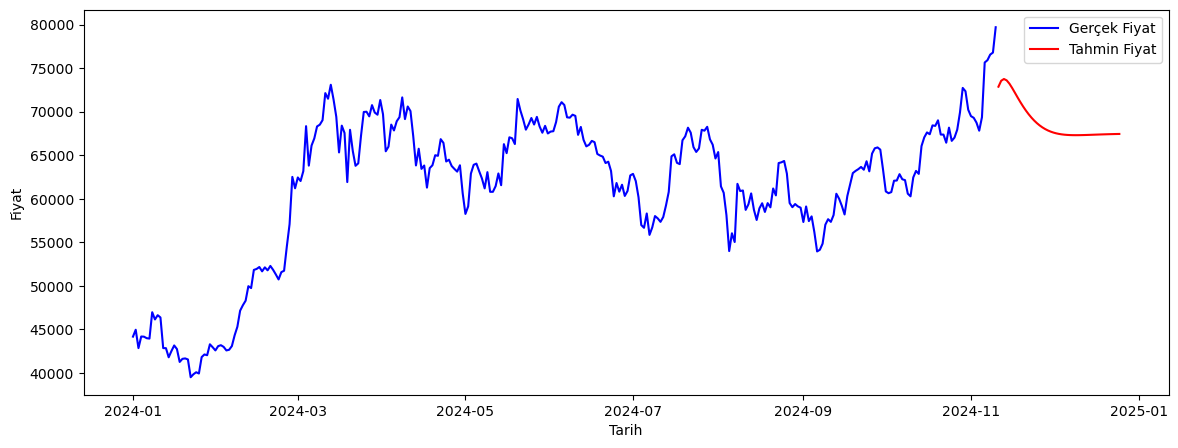

In [59]:
# Yukarıda tanımlanan diğer fonksiyonlar...

# Gelecek günler için tahmin fonksiyonu
def gelecek_tahmin_yap(model, data, scaler, n_gun):
    tahmin_verisi = data[-60:].values
    tahmin_verisi = scaler.transform(tahmin_verisi)
    tahminler = []
    for _ in range(n_gun):
        X_test = np.reshape(tahmin_verisi, (1, tahmin_verisi.shape[0], 1))
        tahmin = model.predict(X_test)
        tahmin_tersi = scaler.inverse_transform(tahmin)
        tahminler.append(tahmin_tersi[0, 0])
        yeni_veri = np.append(tahmin_verisi, tahmin)[1:]
        tahmin_verisi = np.reshape(yeni_veri, (60, 1))
    tarih_araligi = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_gun)
    tahmin_df = pd.DataFrame(data=tahminler, index=tarih_araligi, columns=["Tahmin"])
    return tahmin_df

# Tahmin botu
def tahmin_botu():
    baslangic, bitis = tarih_girdisi_al()
    data = veri_cekme('BTC-USD', baslangic, bitis)
    model, scaler = model_egit(data, epochs=5)
    n_gun = int(input("Kaç gün ileriye tahmin yapmak istiyorsunuz? "))
    tahmin_data = gelecek_tahmin_yap(model, data, scaler, n_gun)
    grafikleri_goster(data, tahmin_data)

# Tahmin botunu başlat
tahmin_botu()
